In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transform
import torchmetrics
import random
import matplotlib
import matplotlib.pyplot as matplot

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, Normalize, Compose
from torchmetrics import F1Score, Accuracy

from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
project_name='rock-paper-scissors'

In [3]:
# Data directory
data_dir = './dataset'
print(os.listdir(data_dir))

# Classes
classes = os.listdir(data_dir)
print(classes)

['paper', 'rock', 'scissors']
['paper', 'rock', 'scissors']


In [4]:
stats=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_tfms = transform.Compose([transform.CenterCrop(224),
                         transform.Resize((32,32)), 
                         transform.RandomHorizontalFlip(), 
                         transform.ToTensor(), 
                         transform.Normalize(*stats,inplace=True)])

valid_tfms = transform.Compose([transform.CenterCrop(224),transform.Resize((32,32)),transform.ToTensor(), transform.Normalize(*stats)])

In [5]:
# Datasets
# train_dataset = ImageFolder(data_dir+'/train', train_tfms)
# valid_dataset = ImageFolder(data_dir+'/validation', valid_tfms)
# test_dataset = ImageFolder(data_dir+'/test', valid_tfms)
# dataset = ImageFolder(data_dir)
rock_paper_scissors_data = ImageFolder(data_dir, train_tfms)

In [6]:
train_size = int(0.85 * len(rock_paper_scissors_data))
test_size = len(rock_paper_scissors_data) - train_size
train_dataset, test_dataset = random_split(rock_paper_scissors_data, [train_size, test_size])

In [7]:
batch_size = 64
num_of_classes = len(classes)
num_of_classes

3

In [ ]:
# Data loaders
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
# val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)

In [ ]:
# Function to show images
def show_images(dataloader):
    for images, labels in dataloader:
        fig, ax = matplot.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break


In [ ]:
show_images(test_dataloader)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
# Moving Dataloader on the device('Cuda' if available)
train_dataloader = DeviceDataLoader(train_dataloader, device)

In [ ]:
# ResNet9 model
class ResNet9(nn.Module):
    def __init__(self):
        super(ResNet9, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
        self.fc = nn.Sequential(nn.MaxPool2d(4),
                                nn.Flatten(), 
                                nn.Dropout(0.2),
                                nn.Linear(512, num_of_classes))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

In [12]:
# SmallResNet9 model
class SmallResNet9(nn.Module):
    def __init__(self):
        super(SmallResNet9, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.fc = nn.Sequential(nn.MaxPool2d(4), 
                      nn.Flatten(), 
                      nn.Dropout(0.2),
                      nn.Linear(256, num_of_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

In [13]:
k = 10
number_of_epochs = 50
learning_rate = 0.001
weight_decay = 1e-4

In [14]:
# F-1 Score
def get_f1score(preds, labels):
    f1_score = F1Score(task="multiclass", num_classes=num_of_classes, average='weighted')
    print(f1_score)
    return f1_score(preds, labels)

In [15]:
# Accuracy
def get_accuracy(preds, labels):
    accuracy = Accuracy(task="multiclass", num_classes=num_of_classes).to(device)
    return accuracy(preds, labels)

In [16]:
# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [17]:
# Evaluate model
def evaluate(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    return all_preds, all_labels

In [18]:
# K-fold cross-validation
kf = KFold(n_splits=k, shuffle=True)

# Train and validate for each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
    print(f'Fold {fold + 1}/{k}')
    
    # Create subset datasets and dataloaders for this fold
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    
    # Model
    model = SmallResNet9()
    model.to(device)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
#   optimizer = optim.Adam(model.parameters(), learning_rate)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Train and validate for this fold
    for epoch in range(number_of_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        val_loss = train(model,val_loader,criterion,optimizer)
        val_preds, val_labels = evaluate(model, val_loader)
        val_accuracy = get_accuracy(val_preds, val_labels)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch + 1} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val accuracy: {val_accuracy:.4f}')
    
    # Saving the Current Fold Model
    torch.save(model, f'fold{fold}.pth')

Fold 1/10
Epoch 1 - Train loss: 0.9305 - Val loss: 0.8021 - Val accuracy: 0.7972
Epoch 2 - Train loss: 0.7402 - Val loss: 0.7267 - Val accuracy: 0.8491
Epoch 3 - Train loss: 0.6996 - Val loss: 0.6919 - Val accuracy: 0.8774
Epoch 4 - Train loss: 0.6763 - Val loss: 0.6909 - Val accuracy: 0.8145
Epoch 5 - Train loss: 0.6599 - Val loss: 0.6590 - Val accuracy: 0.8601
Epoch 6 - Train loss: 0.6491 - Val loss: 0.6537 - Val accuracy: 0.9088
Epoch 7 - Train loss: 0.6399 - Val loss: 0.6524 - Val accuracy: 0.9041
Epoch 8 - Train loss: 0.6354 - Val loss: 0.6426 - Val accuracy: 0.9277
Epoch 9 - Train loss: 0.6309 - Val loss: 0.6302 - Val accuracy: 0.9434
Epoch 10 - Train loss: 0.6190 - Val loss: 0.6227 - Val accuracy: 0.9308
Epoch 11 - Train loss: 0.6185 - Val loss: 0.6123 - Val accuracy: 0.9465
Epoch 12 - Train loss: 0.6074 - Val loss: 0.6014 - Val accuracy: 0.9591
Epoch 13 - Train loss: 0.6065 - Val loss: 0.6152 - Val accuracy: 0.9481
Epoch 14 - Train loss: 0.6031 - Val loss: 0.5976 - Val accuracy

KeyboardInterrupt: 

In [ ]:
# K-fold cross-validation
kf = KFold(n_splits=k, shuffle=True)

# Train and validate for each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
    print(f'Fold {fold + 1}/{k}')
    
    # Create subset datasets and dataloaders for this fold
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    
    # Model
    model = torch.load("./model/256/3Fold-100Epochs/fold1.pth")
    model.to(device)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
#   optimizer = optim.Adam(model.parameters(), learning_rate)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=weight_decay)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Train and validate for this fold
    for epoch in range(number_of_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        val_loss = train(model,val_loader,criterion,optimizer)
        val_preds, val_labels = evaluate(model, val_loader)
        val_accuracy = get_accuracy(val_preds, val_labels)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch + 1} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val accuracy: {val_accuracy:.4f}')
    
    # Saving the Current Fold Model
    torch.save(model, f'fold{fold}.pth')

In [ ]:
def train_for_more_epochs(model,number_of_epochs):
        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        #   optimizer = optim.Adam(model.parameters(), learning_rate)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=weight_decay)
    
        train_losses = []
        val_losses = []
        val_accuracies = []
    
        # Train and validate for this fold
        for epoch in range(number_of_epochs):
            train_loss = train(model, train_dataloader, criterion, optimizer)
            val_loss = train(model,val_dataloader,criterion,optimizer)
            val_preds, val_labels = evaluate(model, val_dataloader)
            val_accuracy = get_accuracy(val_preds, val_labels)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print(f'Epoch {epoch + 1} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val accuracy: {val_accuracy:.4f}')
            
        # Saving the Current Fold Model
        torch.save(model, f'Extra-fold{fold}.pth')

In [ ]:
model = torch.load("./model/256/3Fold-100Epochs/fold1.pth")
model.to(device)
train_for_more_epochs(model,100)

In [ ]:
# Saving the model
torch.save(model, './saved_model.pth')

In [19]:
# Function to plot the losses
def plot_losses():
    matplot.plot(train_losses, '-bx')
    matplot.plot(val_losses, '-rx')
    matplot.xlabel('epoch')
    matplot.ylabel('loss')
    matplot.legend(['Training', 'Validation'])
    matplot.title('Loss vs. No. of epochs');

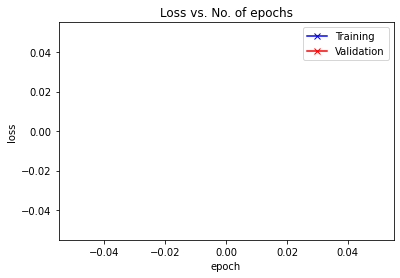

In [20]:
plot_losses()

In [21]:
# Testing the model
test_model = SmallResNet9()
PATH = './fold0.pth'
test_model = torch.load(PATH, map_location = device)
test_model.to(device)

SmallResNet9(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size

In [31]:
# Moving Test Dataloader on the device('Cuda' if available)
test_dataloader = DeviceDataLoader(test_dataloader, device)

In [32]:
# Evaluating Test Data
preds, labels = evaluate(test_model, test_dataloader)

# Accuracy
accuracy = get_accuracy(preds, labels)
accuracy

tensor(0.9626, device='cuda:0')

In [33]:
# F-1 SCORE
f1_score = get_f1score(preds, labels)
f1_score

MulticlassF1Score()


tensor(0.9627)

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

<Axes: >

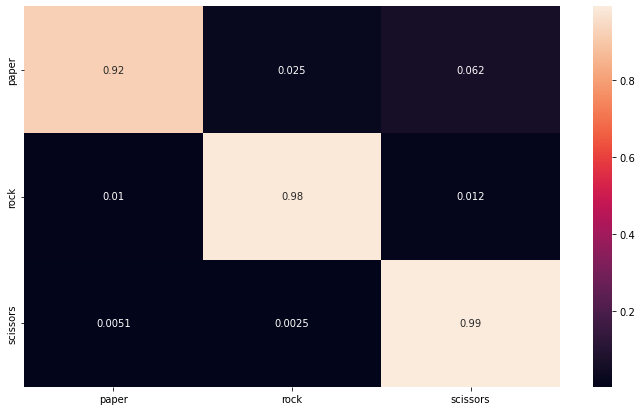

In [35]:
cf_matrix = confusion_matrix(preds, labels)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
matplot.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)